**Chapter 15 – Processing Sequences Using RNNs and CNNs**

_This notebook contains all the sample code in chapter 15._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Basic RNNs

### Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


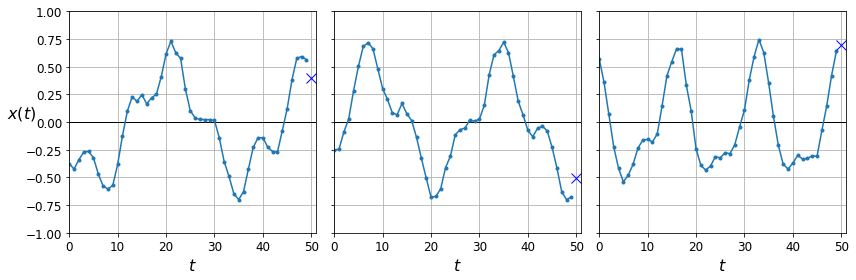

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

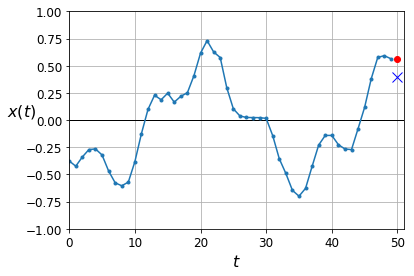

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 51us/sample - loss: 0.1015 - val_loss: 0.0551
Epoch 2/20
7000/7000 [==============================] - 0s 29us/sample - loss: 0.0384 - val_loss: 0.0267
Epoch 3/20
7000/7000 [==============================] - 0s 28us/sample - loss: 0.0205 - val_loss: 0.0161
Epoch 4/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0133 - val_loss: 0.0119
Epoch 5/20
7000/7000 [==============================] - 0s 34us/sample - loss: 0.0104 - val_loss: 0.0099
Epoch 6/20
7000/7000 [==============================] - 0s 35us/sample - loss: 0.0090 - val_loss: 0.0088
Epoch 7/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0081 - val_loss: 0.0079
Epoch 8/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0073 - val_loss: 0.0074
Epoch 9/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0067 - val_loss: 0.0066
Epoch 1

In [9]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 15us/sample - loss: 0.0042


0.004174047667533159

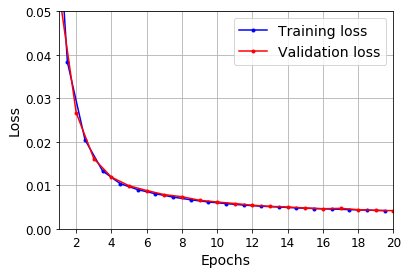

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

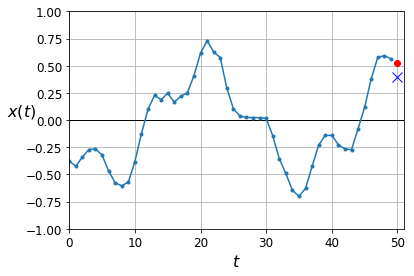

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 513us/sample - loss: 0.0960 - val_loss: 0.0482
Epoch 2/20
7000/7000 [==============================] - 3s 400us/sample - loss: 0.0366 - val_loss: 0.0293
Epoch 3/20
7000/7000 [==============================] - 3s 388us/sample - loss: 0.0251 - val_loss: 0.0216
Epoch 4/20
7000/7000 [==============================] - 3s 372us/sample - loss: 0.0196 - val_loss: 0.0175
Epoch 5/20
7000/7000 [==============================] - 3s 367us/sample - loss: 0.0165 - val_loss: 0.0150
Epoch 6/20
7000/7000 [==============================] - 3s 364us/sample - loss: 0.0145 - val_loss: 0.0133
Epoch 7/20
7000/7000 [==============================] - 3s 390us/sample - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
7000/7000 [==============================] - 3s 361us/sample - loss: 0.0123 - val_loss: 0.0116
Epoch 9/20
7000/7000 [==============================] - 3s 364us/sample - loss: 0.0118 - val_loss: 0.011

In [13]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 179us/sample - loss: 0.0108


0.010848855562508107

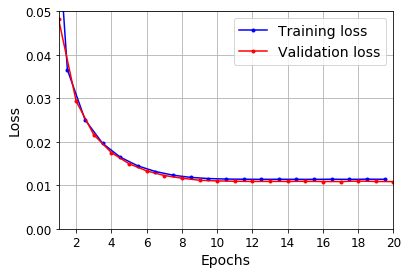

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

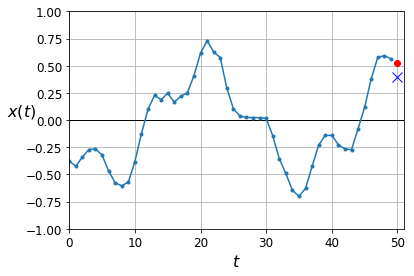

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0502 - val_loss: 0.0093
Epoch 2/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0069 - val_loss: 0.0055
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0050 - val_loss: 0.0044
Epoch 4/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0048 - val_loss: 0.0040
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0041 - val_loss: 0.0037
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0041 - val_loss: 0.0043
Epoch 7/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0038 - val_loss: 0.0036
Epoch 8/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0037 - val_loss: 0.0032
Epoch 9/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 10/20
700

In [17]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 561us/sample - loss: 0.0029


0.0028896138425916432

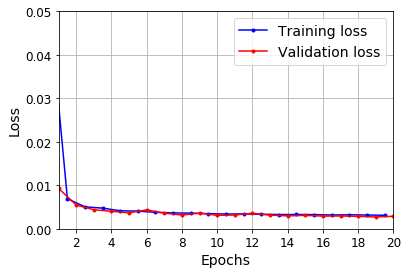

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

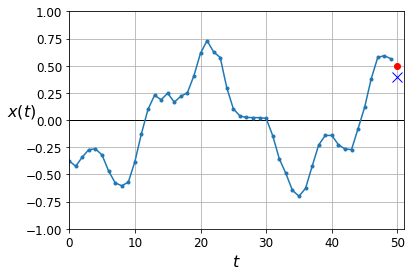

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 992us/sample - loss: 0.0212 - val_loss: 0.0053
Epoch 2/20
7000/7000 [==============================] - 6s 825us/sample - loss: 0.0041 - val_loss: 0.0034
Epoch 3/20
7000/7000 [==============================] - 6s 821us/sample - loss: 0.0034 - val_loss: 0.0031
Epoch 4/20
7000/7000 [==============================] - 6s 922us/sample - loss: 0.0033 - val_loss: 0.0030
Epoch 5/20
7000/7000 [==============================] - 7s 932us/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 6s 894us/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 7/20
7000/7000 [==============================] - 6s 866us/sample - loss: 0.0030 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 6s 892us/sample - loss: 0.0030 - val_loss: 0.0028
Epoch 9/20
7000/7000 [==============================] - 7s 950us/sample - loss: 0.0030 - val_loss: 0.003

In [21]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 334us/sample - loss: 0.0027


0.00267703290656209

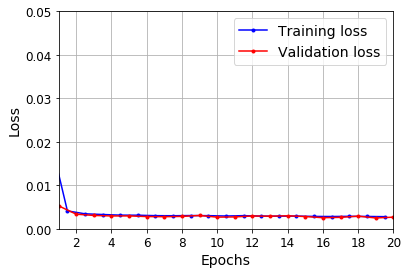

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

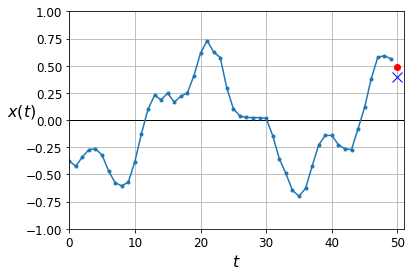

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [24]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [25]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


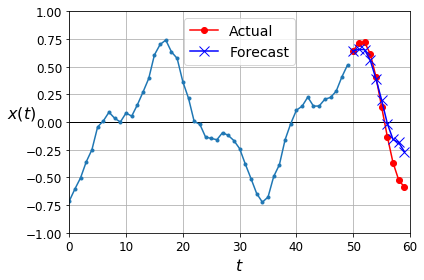

In [26]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's create an RNN that predicts all 10 next values at once:

In [27]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 978us/sample - loss: 0.0670 - val_loss: 0.0341
Epoch 2/20
7000/7000 [==============================] - 6s 838us/sample - loss: 0.0267 - val_loss: 0.0195
Epoch 3/20
7000/7000 [==============================] - 6s 833us/sample - loss: 0.0189 - val_loss: 0.0195
Epoch 4/20
7000/7000 [==============================] - 6s 847us/sample - loss: 0.0152 - val_loss: 0.0129
Epoch 5/20
7000/7000 [==============================] - 6s 850us/sample - loss: 0.0136 - val_loss: 0.0125
Epoch 6/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0126 - val_loss: 0.0128
Epoch 7/20
7000/7000 [==============================] - 6s 803us/sample - loss: 0.0121 - val_loss: 0.0107
Epoch 8/20
7000/7000 [==============================] - 5s 776us/sample - loss: 0.0112 - val_loss: 0.0109
Epoch 9/20
7000/7000 [==============================] - 6s 808us/sample - loss: 0.0109 - val_loss: 0.0106


In [29]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

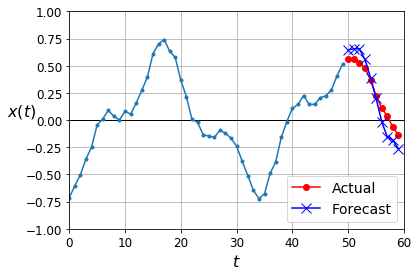

In [30]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [31]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [32]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 997us/sample - loss: 0.0743 - last_time_step_mse: 0.0648 - val_loss: 0.0470 - val_last_time_step_mse: 0.0343
Epoch 2/20
7000/7000 [==============================] - 6s 849us/sample - loss: 0.0440 - last_time_step_mse: 0.0310 - val_loss: 0.0412 - val_last_time_step_mse: 0.0267
Epoch 3/20
7000/7000 [==============================] - 6s 852us/sample - loss: 0.0397 - last_time_step_mse: 0.0258 - val_loss: 0.0379 - val_last_time_step_mse: 0.0232
Epoch 4/20
7000/7000 [==============================] - 6s 861us/sample - loss: 0.0373 - last_time_step_mse: 0.0225 - val_loss: 0.0361 - val_last_time_step_mse: 0.0214
Epoch 5/20
7000/7000 [==============================] - 6s 876us/sample - loss: 0.0359 - last_time_step_mse: 0.0211 - val_loss: 0.0355 - val_last_time_step_mse: 0.0205
Epoch 6/20
7000/7000 [==============================] - 7s 929us/sample - loss: 0.0345 - last_time_step_mse: 0.0

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

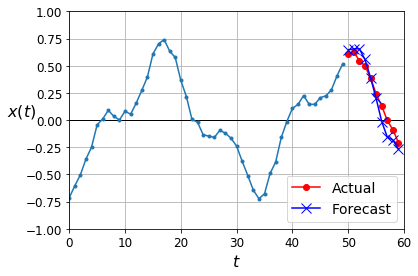

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNN with Batch Norm

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.1939 - last_time_step_mse: 0.1922 - val_loss: 0.0876 - val_last_time_step_mse: 0.0834
Epoch 2/20
7000/7000 [==============================] - 7s 987us/sample - loss: 0.0536 - last_time_step_mse: 0.0448 - val_loss: 0.0553 - val_last_time_step_mse: 0.0467
Epoch 3/20
7000/7000 [==============================] - 7s 933us/sample - loss: 0.0472 - last_time_step_mse: 0.0377 - val_loss: 0.0450 - val_last_time_step_mse: 0.0353
Epoch 4/20
7000/7000 [==============================] - 7s 929us/sample - loss: 0.0438 - last_time_step_mse: 0.0338 - val_loss: 0.0423 - val_last_time_step_mse: 0.0331
Epoch 5/20
7000/7000 [==============================] - 6s 917us/sample - loss: 0.0408 - last_time_step_mse: 0.0304 - val_loss: 0.0394 - val_last_time_step_mse: 0.0285
Epoch 6/20
7000/7000 [==============================] - 6s 914us/sample - loss: 0.0385 - last_time_step_mse: 0.027

# Deep RNNs with Layer Norm

In [37]:
from tensorflow.keras.layers import LayerNormalization

In [38]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.1638 - last_time_step_mse: 0.1463 - val_loss: 0.0718 - val_last_time_step_mse: 0.0670
Epoch 2/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0620 - last_time_step_mse: 0.0533 - val_loss: 0.0551 - val_last_time_step_mse: 0.0432
Epoch 3/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0520 - last_time_step_mse: 0.0402 - val_loss: 0.0485 - val_last_time_step_mse: 0.0365
Epoch 4/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0460 - last_time_step_mse: 0.0335 - val_loss: 0.0435 - val_last_time_step_mse: 0.0300
Epoch 5/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0419 - last_time_step_mse: 0.0294 - val_loss: 0.0399 - val_last_time_step_mse: 0.0276
Epoch 6/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0391 - last_time_step_mse: 0.0267 - 

# Creating a Custom RNN Class

In [40]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.2280 - last_time_step_mse: 0.2059 - val_loss: 0.1155 - val_last_time_step_mse: 0.1047
Epoch 2/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0883 - last_time_step_mse: 0.0784 - val_loss: 0.0637 - val_last_time_step_mse: 0.0526
Epoch 3/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0543 - last_time_step_mse: 0.0407 - val_loss: 0.0480 - val_last_time_step_mse: 0.0319
Epoch 4/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0450 - last_time_step_mse: 0.0300 - val_loss: 0.0416 - val_last_time_step_mse: 0.0261
Epoch 5/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0403 - last_time_step_mse: 0.0253 - val_loss: 0.0386 - val_last_time_step_mse: 0.0223
Epoch 6/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0380 - last_time_step_mse: 0.0235 - 

# LSTMs

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0759 - last_time_step_mse: 0.0615 - val_loss: 0.0551 - val_last_time_step_mse: 0.0364
Epoch 2/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0477 - last_time_step_mse: 0.0275 - val_loss: 0.0421 - val_last_time_step_mse: 0.0211
Epoch 3/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0390 - last_time_step_mse: 0.0183 - val_loss: 0.0364 - val_last_time_step_mse: 0.0151
Epoch 4/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0351 - last_time_step_mse: 0.0152 - val_loss: 0.0336 - val_last_time_step_mse: 0.0132
Epoch 5/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0327 - last_time_step_mse: 0.0135 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0311 - last_time_step_mse: 0.0126 - 

In [43]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 1s 677us/sample - loss: 0.0237 - last_time_step_mse: 0.0085


[0.023689543694257735, 0.008518973]

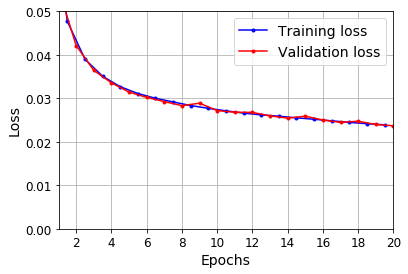

In [44]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [45]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

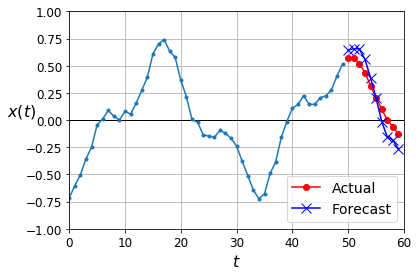

In [46]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0742 - last_time_step_mse: 0.0667 - val_loss: 0.0528 - val_last_time_step_mse: 0.0414
Epoch 2/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0476 - last_time_step_mse: 0.0365 - val_loss: 0.0440 - val_last_time_step_mse: 0.0326
Epoch 3/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0418 - last_time_step_mse: 0.0303 - val_loss: 0.0394 - val_last_time_step_mse: 0.0271
Epoch 4/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0373 - last_time_step_mse: 0.0249 - val_loss: 0.0359 - val_last_time_step_mse: 0.0226
Epoch 5/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0328 - last_time_step_mse: 0.0181 - val_loss: 0.0316 - val_last_time_step_mse: 0.0168
Epoch 6/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0308 - last_time_step_mse: 0.0157 - 

In [48]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 2s 770us/sample - loss: 0.0246 - last_time_step_mse: 0.0111


[0.024557729810476304, 0.011060879]

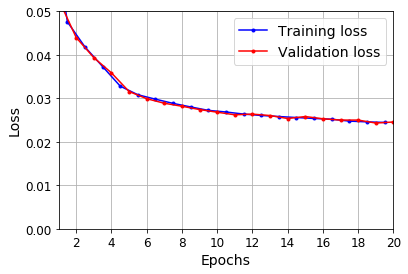

In [49]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [50]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

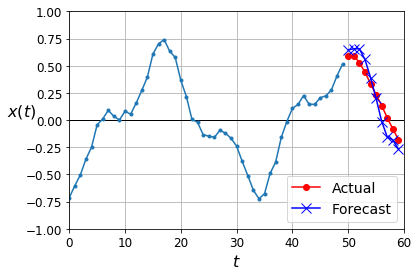

In [51]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0681 - last_time_step_mse: 0.0608 - val_loss: 0.0477 - val_last_time_step_mse: 0.0397
Epoch 2/20
7000/7000 [==============================] - 7s 962us/sample - loss: 0.0411 - last_time_step_mse: 0.0338 - val_loss: 0.0367 - val_last_time_step_mse: 0.0287
Epoch 3/20
7000/7000 [==============================] - 7s 966us/sample - loss: 0.0339 - last_time_step_mse: 0.0259 - val_loss: 0.0310 - val_last_time_step_mse: 0.0217
Epoch 4/20
7000/7000 [==============================] - 7s 941us/sample - loss: 0.0284 - last_time_step_mse: 0.0186 - val_loss: 0.0260 - val_last_time_step_mse: 0.0151
Epoch 5/20
7000/7000 [==============================] - 7s 943us/sample - loss: 0.0248 - last_time_step_mse: 0.0140 - val_loss: 0.0243 - val_last_time_step_mse: 0.0137
Epoch 6/20
7000/7000 [==============================] - 6s 928us/sample - loss: 0.0234 - last_time_step_mse: 0.012

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 451us/sample - loss: 0.0668 - last_time_step_mse: 0.0546 - val_loss: 0.0376 - val_last_time_step_mse: 0.0249
Epoch 2/20
7000/7000 [==============================] - 2s 302us/sample - loss: 0.0325 - last_time_step_mse: 0.0202 - val_loss: 0.0296 - val_last_time_step_mse: 0.0175
Epoch 3/20
7000/7000 [==============================] - 2s 286us/sample - loss: 0.0284 - last_time_step_mse: 0.0170 - val_loss: 0.0269 - val_last_time_step_mse: 0.0153
Epoch 4/20
7000/7000 [==============================] - 2s 305us/sample - loss: 0.0264 - last_time_step_mse: 0.0149 - val_loss: 0.0256 - val_last_time_step_mse: 0.0138
Epoch 5/20
7000/7000 [==============================] - 2s 303us/sample - loss: 0.0251 - last_time_step_mse: 0.0135 - val_loss: 0.0244 - val_last_time_step_mse: 0.0128
Epoch 6/20
7000/7000 [==============================] - 2s 301us/sample - loss: 0.0244 - last_time_step_mse: 0.0

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [54]:
from tensorflow import keras

class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [55]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [56]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [57]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/2
7000/7000 [==============================] - 4s 546us/sample - loss: 0.1300 - last_time_step_mse: 0.1261 - val_loss: 0.1230 - val_last_time_step_mse: 0.1200
Epoch 2/2
7000/7000 [==============================] - 3s 410us/sample - loss: 0.1222 - last_time_step_mse: 0.1178 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189


In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

# Exercise solutions

## 1. to 6.

See Appendix A.

## 7. Embedded Reber Grammars

First we need to build a function that generates strings based on a grammar. The grammar will be represented as a list of possible transitions for each state. A transition specifies the string to output (or a grammar to generate it) and the next state.

In [58]:
np.random.seed(42)

default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

Let's generate a few strings based on the default Reber grammar:

In [59]:
for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

Looks good. Now let's generate a few strings based on the embedded Reber grammar:

In [60]:
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE BPBTSSSSSXXTTVPXVPXTTTVVEPE BPBTSSXXTVPSEPE BPBPTTTTTTTVPSEPE BTBTSXSETE BPBPTVPXVVEPE BPBPVVEPE BPBPTVVEPE BTBPTTVPXTTVPSETE BTBTSSXSETE BTBTXXTTVVETE BPBTSXSEPE BPBPTVPSEPE BTBPVVETE BPBTXXTTTVPXTVVEPE BPBPTTVPXTVVEPE BTBPVVETE BPBPTVPXVPXTVVEPE BTBPVVETE BPBTSXSEPE 

Okay, now we need a function to generate strings that do not respect the grammar. We could generate a random string, but the task would be a bit too easy, so instead we will generate a string that respects the grammar, and we will corrupt it by changing just one character:

In [61]:
def generate_corrupted_string(grammar, chars="BEPSTVX"):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

Let's look at a few corrupted strings:

In [62]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTTTXXVVETE BPBTXXSPXTVVEPE BTBTXSPTE BPTTSXXTVPXVVEPE PPBPVPSEPE BTBPTVETE BPTTSSSSSXSEPE BPBSVPSEPE BTBPVVESE BPBTXSEPS BEBTXSETE XPBTXXTVPSEPE BTBPVVEPE BTXPTVVETE BTBPVXETE BVBTXSETE BPTTXXVPXVPSEPE BTBPXVPSETE STBPTTVPXVPXTVPSETE BPBPTVPSESE BPBPVEEPE ETBTXSETE BTBTXSVTE BPBTXXVPSEPP BTBTXXVPSETS 

To be continued...